In [1]:
import pandas as pd #for tabulated data
import numpy as np #speedy operations on tables

import matplotlib.pyplot as plt #plots
import seaborn as sns #nicer plots
#some fancy plots stuff:
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
#from matplotlib.patches import Patch 
import matplotlib.patches as mpatches
import matplotlib.cm as cm

#dealing with dates and time
import datetime
import matplotlib.dates as dates

import re #regular expressions

#loading data from google sheets
import gspread
from oauth2client.service_account import ServiceAccountCredentials

import sys
from df2gspread import df2gspread as d2g
import scipy.stats as stats

C:\Users\Alicja\Work\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [86]:
#plt.rcParams

In [110]:
months = ['January', 'February', 'March', 
          'April', 'May', 'June',
         'July', 'August', 'September', 
          'October', 'November', 'December']
months_abb = ['Jan', 'Feb', 'Mar', 
             'Apr', 'May', 'Jun', 
             'Jul', 'Aug', 'Sep', 
             'Oct', 'Nov', 'Dec']

weekdays_abb = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14
title_size = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=title_size)  # fontsize of the figure title

## Data Loading and Cleaning

Loading data from Google sheets:

In [3]:
scope = ['https://spreadsheets.google.com/feeds']

# Give the path to the Service Account Credential json file 
credentials = ServiceAccountCredentials.from_json_keyfile_name('key/data-analysis-jupyter-5431f3097178.json',
                                                               scope
                                                              )
# Authorise your Notebook
gc = gspread.authorize(credentials)

# The sprad sheet ID, which can be taken from the link to the sheet
spreadsheet_key = '1nU4LKQSrn194_J79vpps0wbS6N-pS_TWl7J20hyn9Sg'

Getting the data into a pd dataframe:

In [4]:
book = gc.open_by_key(spreadsheet_key)
worksheet = book.worksheet("data")
table = worksheet.get_all_values()
data = pd.DataFrame(table[1:], columns=table[0])

Converting date column into datetime

In [5]:
data['date'] = pd.to_datetime(data['date'], format = '%d/%m/%y')
data['date'] = data['date'].dt.date

data['day'] = pd.DatetimeIndex(data['date']).day
data['month'] = pd.DatetimeIndex(data['date']).month
data['weekday'] = pd.DatetimeIndex(data['date']).weekday

for name in ['morning', 'afternoon', 'evening']:
    data[name] = pd.to_numeric(data[name])
    
data = data.set_index(data['date'])

In [6]:
data.head()

,date,location,morning,afternoon,evening,alcohol?,0:00,0:15,0:30,0:45,...,22:30,22:45,23:00,23:15,23:30,23:45,notes,day,month,weekday
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,2020-01-01,"PL, Waw",NaN,NaN,NaN,lots,Ch_Fr_3,Ch_Fr_3,Ch_Fr_3,Ch_Fr_3,...,T_Fam_2,P-SM,P-SM,P-SM,P-SM,P-SM,,1,1,2
2020-01-02,2020-01-02,"PL, Pos",NaN,NaN,NaN,no,P-SM,S,S,S,...,C-B,C-B,C-B,C-B,C-B,Ch-e_Fr_1,,2,1,3
2020-01-03,2020-01-03,"PL, Pos",NaN,NaN,NaN,no,Ch_F_1,Ch_F_1,WL-A,S,...,WL-O,WL-O,WL-O,P-SM,P-SM,C-L,,3,1,4
2020-01-04,2020-01-04,"PL, Pos",NaN,NaN,NaN,no,P-SM,S,S,S,...,C-F_Fr_1,C-F_Fr_1,C-F_Fr_1,C-F_Fr_1,C-F_Fr_1,C-F_Fr_1,Filip visiting,4,1,5
2020-01-05,2020-01-05,"PL, Krk",NaN,NaN,NaN,no,C-F_Fr_1,C-F_Fr_1,C-F_Fr_1,S,...,C-F_Fr_1,C-F_Fr_1,Ch_Fr_1,Ch_Fr_1,Ch_Fr_1,Ch_Fr_1,Filip visiting,5,1,6


Sectioning data table to get just the activities:

In [7]:
cols = list(data.columns)

start = cols.index("0:00")
end = cols.index("23:45")

act_ind = cols[start:end+1]

activities = data[act_ind]

activities = activities.set_index(data['date'])
activities.columns = pd.to_datetime(activities.columns, format = '%H:%M').time

activities.head()

,00:00:00,00:15:00,00:30:00,00:45:00,01:00:00,01:15:00,01:30:00,01:45:00,02:00:00,02:15:00,...,21:30:00,21:45:00,22:00:00,22:15:00,22:30:00,22:45:00,23:00:00,23:15:00,23:30:00,23:45:00
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,Ch_Fr_3,Ch_Fr_3,Ch_Fr_3,Ch_Fr_3,Ch_Fr_3,Ch_Fr_3,Ch_Fr_3,Ch_Fr_3,Ch_Fr_3,Ch_Fr_3,...,T,T_Fam_2,T_Fam_2,T_Fam_2,T_Fam_2,P-SM,P-SM,P-SM,P-SM,P-SM
2020-01-02,P-SM,S,S,S,S,S,S,S,S,S,...,Q,C-B,C-B,C-B,C-B,C-B,C-B,C-B,C-B,Ch-e_Fr_1
2020-01-03,Ch_F_1,Ch_F_1,WL-A,S,S,S,S,S,S,S,...,WL-O,WL-O,WL-O,WL-O,WL-O,WL-O,WL-O,P-SM,P-SM,C-L
2020-01-04,P-SM,S,S,S,S,S,S,S,S,S,...,H,H,C-F_Fr_1,C-F_Fr_1,C-F_Fr_1,C-F_Fr_1,C-F_Fr_1,C-F_Fr_1,C-F_Fr_1,C-F_Fr_1
2020-01-05,C-F_Fr_1,C-F_Fr_1,C-F_Fr_1,S,S,S,S,S,S,S,...,C-F_Fr_1,C-F_Fr_1,C-F_Fr_1,C-F_Fr_1,C-F_Fr_1,C-F_Fr_1,Ch_Fr_1,Ch_Fr_1,Ch_Fr_1,Ch_Fr_1


Daily time on different activities (broad categories):

In [8]:
categories_broad = ['sleep', 'High intensity work', 'Low intensity work', 
              'Human function', 'Procrastination', 'Culture',
             'Socialising', 'Other quality time', 'Travelling', 
              'Idle', 'High intensity exercise', 'Low intensity exercise']

shortcuts_broad = ['^S', r'^WI.*', r'^WL.*',
            r'^H.?', r'^P.*', r'^C-.*',
             r'^Ch.*', r'^Q.*', r'^T.*', 
             r'^I.*', r'^ExI.*', r'^ExL.*']

summary_broad = pd.DataFrame(index = data['date'], columns = categories_broad)

for cat, short in zip(categories_broad, shortcuts_broad):
    for i in range(len(data['date'])):
        summary_broad[cat].iloc[i] = activities.iloc[i].str.count(short).sum()*0.25

        
for column in summary_broad.columns:
    summary_broad[column] = pd.to_numeric(summary_broad[column])

summary_broad.head()

,sleep,High intensity work,Low intensity work,Human function,Procrastination,Culture,Socialising,Other quality time,Travelling,Idle,High intensity exercise,Low intensity exercise
date,,,,,,,,,,,,
2020-01-01,7.00,0.00,0.00,0.25,1.25,3.75,7.00,0.0,4.75,0.0,0.00,0.00
2020-01-02,9.75,4.00,0.75,0.25,4.50,2.00,1.75,1.0,0.00,0.0,0.00,0.00
2020-01-03,9.75,4.00,5.50,0.75,1.75,0.50,1.75,0.0,0.00,0.0,0.00,0.00
2020-01-04,8.00,0.00,0.50,0.75,0.25,2.25,7.75,0.5,1.25,0.0,0.00,2.75
2020-01-05,7.00,1.75,0.75,0.75,0.00,4.75,5.25,1.5,0.00,0.0,0.75,1.50


Points:

Points for different activities: 
- sleep - -2 for sleeping in late (sleeping after 8:30), -1 for not sleeping after 1 (except when with friends)
- High intensity work
    - uni +4
    - self-improvement +4
    - organisation +1
    - admin +1
- Low intensity work
    - uni +2
    - self-improvement +2
    - organisation 0
    - admin 0
- Human function 0
- Procrastination -4
- Culture
    - books +3
    - films +3
    - documentaries +2
    - TV 0
- Socialising 0
- Quality time 
    - reading blogs +2
    - podcasts +2
    - news +1
    - wikipedia +2
    - games 0
    - youtube 0
- Travelling 0
- Idle 0
- High intensity exercise +4
- Low intensity exercise 1

Potentially increase marks for working between 9 and 17 and reduce marks for everything other than work in this time.

In [9]:
categories_detail = ['sleep', 
                      'HI uni', 'HI self-improvement', 'HI organisation', 'HI admin', 'HI German',
                      'LI uni', 'LI self-improvement', 'LI organisation', 'LI admin', 'LI German',
                      'Human function', 
                      'Procrastination', 
                      'Culture - books', 'Culture - films', 'Culture - documentaries', 'Culture - TV', 
                     'Socialising', 
                      'Quality - blogs', 'Quality - podcasts', 'Quality - news', 'Quality - wikipedia', 'Quality - games', 'Quality - YT', 'Quality - chill',
                      'Travelling', 
                      'Idle', 
                      'High intensity exercise', 'Low intensity exercise']

shortcuts_detail = ['^S', 
                     r'WI-U.*', r'WI-I.*', r'WI-O.*', r'WI-A.*', r'WI-Ger.*',
                     r'WL-U.*', r'WL-I.*', r'WL-O.*', r'WL-A.*', r'WL-Ger.*',
                     r'^H.?', 
                     r'^P.*', 
                     r'C-B.*', r'C-F.*', r'C-D.*', r'C-TV.*',
                     r'^Ch.*', 
                     r'Q-Bl.*', r'Q-P.*', r'Q-N.*', r'Q-Wk.*', r'Q-G.*', r'Q-YT.*',  r'Q-ch.*',
                     r'^T.*', 
                     r'^I.*', 
                     r'^ExI.*', r'^ExL.*']

grades = [0,
          4, 4, 1, 1, 4,
          2, 2, 1, 1, 2,
          0, 
          -4, 
          3, 2, 1, 0,
          0, 
          2, 2, 1, 2, 0, 0, 0,
          0, 
          0, 
          4, 1]

Daily time on different activities (broad categories):

In [10]:
summary_detail = pd.DataFrame(index = data['date'], columns = categories_detail)

for cat, short in zip(categories_detail, shortcuts_detail):
    for i in range(len(data['date'])):
        summary_detail[cat].iloc[i] = activities.iloc[i].str.count(short).sum()*0.25

        
for column in summary_detail.columns:
    summary_detail[column] = pd.to_numeric(summary_detail[column])

In [11]:
summary_detail.tail(12)

,sleep,HI uni,HI self-improvement,HI organisation,HI admin,HI German,LI uni,LI self-improvement,LI organisation,LI admin,...,Quality - podcasts,Quality - news,Quality - wikipedia,Quality - games,Quality - YT,Quality - chill,Travelling,Idle,High intensity exercise,Low intensity exercise
date,,,,,,,,,,,,,,,,,,,,,
2020-12-15,6.75,6.75,0.25,0.0,0.5,0.00,0.50,0.00,0.00,1.50,...,0.50,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.75
2020-12-16,7.00,6.25,0.00,0.0,0.5,0.00,0.00,2.50,0.00,0.50,...,0.75,0.00,0.0,0.0,0.25,0.00,0.00,0.00,0.5,0.25
2020-12-17,7.25,7.50,0.25,0.0,0.0,0.00,0.00,0.00,0.00,1.25,...,0.75,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.5,0.75
2020-12-18,6.75,3.25,0.00,0.0,0.0,0.75,0.00,0.25,0.00,2.00,...,2.50,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.5,1.50
2020-12-19,4.75,0.00,0.00,0.0,0.0,0.00,0.00,1.25,0.00,0.00,...,2.50,0.00,0.0,0.0,0.00,0.25,8.00,1.00,0.0,3.00
2020-12-20,8.00,0.00,1.25,0.0,0.0,1.00,0.00,0.25,0.75,1.50,...,0.25,0.25,0.0,0.0,0.00,0.75,1.25,0.00,0.0,1.75
2020-12-21,7.50,2.00,0.00,0.0,0.0,0.00,1.50,0.00,0.00,1.00,...,2.50,0.00,0.0,0.0,0.00,0.00,1.25,0.50,0.0,2.00
2020-12-22,5.50,3.00,5.25,0.0,0.0,0.00,0.25,0.00,0.00,1.00,...,0.25,0.00,0.0,0.0,0.00,0.00,1.00,0.25,0.0,1.25
2020-12-23,7.50,2.75,4.00,0.0,0.0,0.00,0.00,3.75,0.00,0.00,...,2.00,0.00,0.0,0.0,0.00,0.00,0.00,0.25,0.0,0.00


In [12]:
summary_detail.mean()

sleep                      7.637119
HI uni                     3.035319
HI self-improvement        0.723684
HI organisation            0.018698
HI admin                   0.049169
HI German                  0.569945
LI uni                     0.369114
LI self-improvement        0.418975
LI organisation            0.202909
LI admin                   0.879501
LI German                  0.097645
Human function             1.364958
Procrastination            0.341413
Culture - books            1.394044
Culture - films            0.139197
Culture - documentaries    0.103878
Culture - TV               0.153740
Socialising                3.292244
Quality - blogs            0.150970
Quality - podcasts         0.323407
Quality - news             0.049861
Quality - wikipedia        0.000000
Quality - games            0.130886
Quality - YT               0.067867
Quality - chill            0.226454
Travelling                 0.869806
Idle                       0.121191
High intensity exercise    0

In [13]:
#multiply the detailed summary by grade for each category to get dataframe of grades
ocenki = summary_detail.multiply(grades)

#sleep separate as is complicated
for i in range(len(data['date'])):
    not_in_bed = activities.iloc[i,4:20].str.count(r'^((?!S).)*$').sum()*-1*0.25 #-1 for not sleeping after 1 am
    #penatly doesn't work if time is spent with friends or on traveling
    frens = activities.iloc[i,4:20].str.count(r'^Ch.*').sum()*1*0.25 
    travel = activities.iloc[i,4:20].str.count(r'^T.*').sum()*1*0.25
    
    still_in_bed = activities.iloc[i,33:-5].str.count('^S').sum()*-2*0.25 #-2 per hour for not being awake after 8:30
    
    ocenki['sleep'].iloc[i] = not_in_bed + frens + travel + still_in_bed

In [14]:
ocenki.head()

,sleep,HI uni,HI self-improvement,HI organisation,HI admin,HI German,LI uni,LI self-improvement,LI organisation,LI admin,...,Quality - podcasts,Quality - news,Quality - wikipedia,Quality - games,Quality - YT,Quality - chill,Travelling,Idle,High intensity exercise,Low intensity exercise
date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,-9.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2020-01-02,-3.5,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2020-01-03,-4.5,16.0,0.0,0.0,0.0,0.0,0.0,0.0,4.75,0.75,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.50,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.75
2020-01-05,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.50,0.25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.50


In [15]:
data['av_mood'] = data[['morning', 'afternoon', 'evening']].mean(axis = 1)

data['av_mood'][:17] = [6.0, 3.0, 3.0, 6.0, 5.0, 4.0, 5.0, 
                        3.0, 5.0, 6.0, 6.0, 4.0, 5.0, 5.0, 
                        5.0, 5.0, 4.0]

C:\Users\Alicja\Work\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


### To summarise:

So I have:
- loaded data from Google Sheets
- made a few tidy(ish) dataframes: 
    - data - contains all data from the google sheet
    - activities - informs which activity was done at what time of day (rows are days, columns are times, entries are activity shortcuts)
    - summary_broad - gives the sum of hours spent on activities (broad categories) each day (rows are days, columns are activities, entries are numbers of hours)
    - summary_detailed - gives the sum of hours spent on activities (detailed categories) each day (rows are days, columns are activities, entries are numbers of hours) - should have a column for all categories (probably not the case though)
    - ocenki - gives the grades for different activities everyday (rows are days, columns are detailed categories, entries are grades)

### Fitbit data

Sleep 
(also have data on activity levels to be dealt with at some other time)

In [16]:
#fitbit only allows to download data from 30 days together, have to load data for each month and then concatenate it into a single table
fitbit_sleep = pd.read_csv('fitbit_data/fitbit_January_sleep.csv', header = 1)

for month in months[1:]:
        try:
            temp = pd.read_csv('fitbit_data/fitbit_' + month + '_sleep.csv', header = 1)
            fitbit_sleep = pd.concat([fitbit_sleep, temp])
        except FileNotFoundError:
            break

convert dates in fitbit df to datatime objects

In [17]:
print(fitbit_sleep['Start Time'][1])

fitbit_sleep['Start Time'] = pd.to_datetime(fitbit_sleep['Start Time'], format = '%d-%m-%Y %I:%M %p')
fitbit_sleep['End Time'] = pd.to_datetime(fitbit_sleep['End Time'], format = '%d-%m-%Y %I:%M %p')

1    29-01-2020 12:20 am
1     28-02-2020 2:25 am
1    30-03-2020 12:54 am
1    24-04-2020 12:47 am
1    30-05-2020 12:43 am
1    29-06-2020 12:56 am
Name: Start Time, dtype: object


In [18]:
fitbit_sleep.head()

,Start Time,End Time,Minutes Asleep,Minutes Awake,Number of Awakenings,Time in Bed,Minutes REM Sleep,Minutes Light Sleep,Minutes Deep Sleep
0,2020-01-31 01:12:00,2020-01-31 07:07:00,314,41,29,355,74.0,147.0,93.0
1,2020-01-29 00:20:00,2020-01-29 07:17:00,369,48,27,417,71.0,200.0,98.0
2,2020-01-27 22:57:00,2020-01-28 05:47:00,355,55,31,410,89.0,163.0,103.0
3,2020-01-27 00:47:00,2020-01-27 04:13:00,186,20,11,206,23.0,133.0,30.0
4,2020-01-26 01:38:00,2020-01-26 08:02:00,335,48,21,383,90.0,197.0,48.0


## Visualisations

In [19]:
#getting the basic matplotlib colourmap because its nice
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

### Grades

In [20]:
ocenki.max().max()

43.0

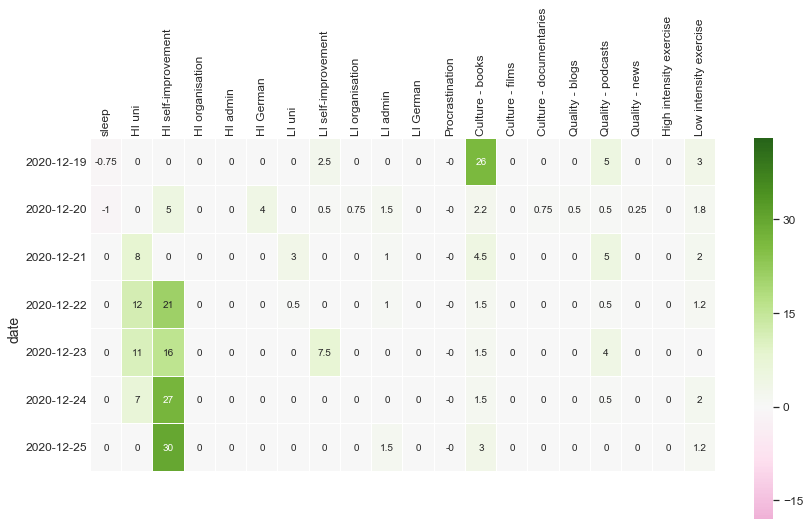

scores for each of the days:
date
2020-12-19    36.00
2020-12-20    16.75
2020-12-21    23.50
2020-12-22    37.75
2020-12-23    40.00
2020-12-24    38.00
2020-12-25    35.75
dtype: float64

total score for the past 7 days: 227.75
mean daily score for the past 7 days: 32.54
mean mood for the past 7 days: 6.1


In [101]:
nd = 8 #number of days I want to look at

ocenki_week = ocenki.iloc[-nd:-1]

nonzero_ocenki = ocenki_week.loc[:, (ocenki != 0).any(axis=0)]

fig = plt.figure(figsize = (14,nd-1))

sns.heatmap(nonzero_ocenki, annot = True, 
            cmap = 'PiYG', center = 0,
            linewidth = 0.05, 
            vmin=ocenki.min().min(), vmax=ocenki.max().max())

ax = plt.gca()
plt.gca().xaxis.tick_top()
plt.xticks(rotation=90)
ax.tick_params(length = 0)

plt.yticks(np.arange(nd)+0.5, rotation=0, va="center")

bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

print('scores for each of the days:')
print(ocenki.iloc[-nd:-1].sum(axis = 1))

print('\ntotal score for the past ' + str(nd-1) + ' days: ' + str(ocenki.sum(axis = 1).values[-nd:-1].sum()))
print('mean daily score for the past ' + str(nd-1) + ' days: ' + str(round(ocenki.sum(axis = 1).values[-nd:-1].mean(),2)))

print('mean mood for the past ' + str(nd-1) + ' days: ' + str(round(data['av_mood'].values[-nd:-1].mean(),2)))
#print(round(data['av_mood'].values[-nd:-1].mean(),2))

In [22]:
summary_detail.iloc[-nd:-1].sum()[summary_detail.iloc[-nd:-1].sum() != 0]

sleep                      47.00
HI uni                      9.50
HI self-improvement        24.75
HI German                   1.00
LI uni                      1.75
LI self-improvement         5.25
LI organisation             0.75
LI admin                    5.00
Human function             10.00
Culture - books            13.50
Culture - documentaries     0.75
Socialising                28.50
Quality - blogs             0.25
Quality - podcasts          7.75
Quality - news              0.25
Quality - chill             1.00
Travelling                 12.50
Idle                        2.00
Low intensity exercise     11.25
dtype: float64

In [23]:
print(ocenki.iloc[-1])
print(ocenki.iloc[-1].sum())

sleep                      0.0
HI uni                     0.0
HI self-improvement        3.0
HI organisation            0.0
HI admin                   0.0
HI German                  0.0
LI uni                     0.0
LI self-improvement        0.0
LI organisation            0.0
LI admin                   0.0
LI German                  0.0
Human function             0.0
Procrastination           -0.0
Culture - books            0.0
Culture - films            0.0
Culture - documentaries    0.0
Culture - TV               0.0
Socialising                0.0
Quality - blogs            0.5
Quality - podcasts         0.0
Quality - news             0.0
Quality - wikipedia        0.0
Quality - games            0.0
Quality - YT               0.0
Quality - chill            0.0
Travelling                 0.0
Idle                       0.0
High intensity exercise    0.0
Low intensity exercise     0.0
Name: 2020-12-26, dtype: float64
3.5


Add a 'daily_ocenki' column to the data df with the total daily grade

In [24]:
data['daily_ocenki'] = ocenki.sum(axis = 1).values

print(data['daily_ocenki'].mean())
print(data['daily_ocenki'].median())
print(data['daily_ocenki'].std())

26.691828254847646
27.5
14.248796576217291


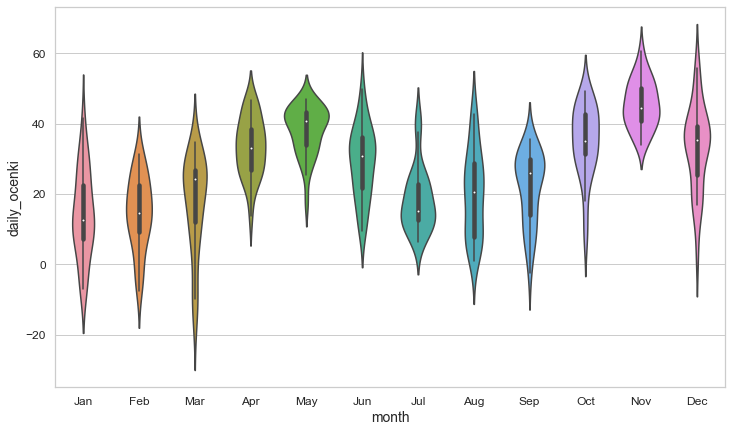

In [104]:
plt.figure(figsize = (12,7))

sns.violinplot(x = data['month'], 
               y = data['daily_ocenki'])

'''
sns.stripplot(data=data,
              x='month',
              y='av_mood',
              jitter=0.1, 
              alpha=0.5)
'''

n = len(np.unique(data['month']))

ax = plt.gca()
ax.set_xticklabels(months_abb[:n])

plt.show()

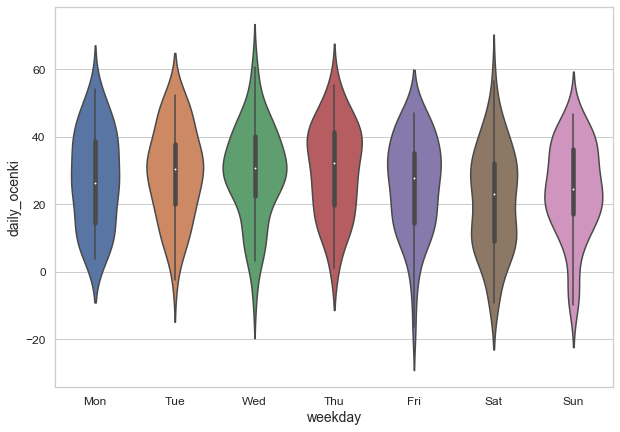

In [111]:
plt.figure(figsize = (10,7))

sns.violinplot(x = data['weekday'], y = data['daily_ocenki'], alpha = 0.5)

ax = plt.gca()
ax.set_xticklabels(weekdays_abb)

plt.show()

### Mood

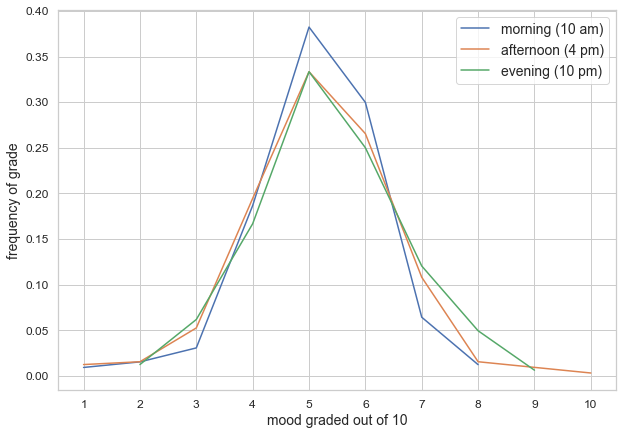

In [106]:
plt.figure(figsize = (10,7))

for item in ['morning', 'afternoon', 'evening'] :
    temp = data[item]
    temp = temp[~np.isnan(temp)]
    val, counts = np.unique(temp, return_counts = 1)
    counts = counts/len(temp)
    plt.plot(val, counts)
    

plt.legend(['morning (10 am)', 'afternoon (4 pm)', 'evening (10 pm)'])   
plt.xticks(range(1,11))
plt.xlabel('mood graded out of 10')
plt.ylabel('frequency of grade')
plt.show()

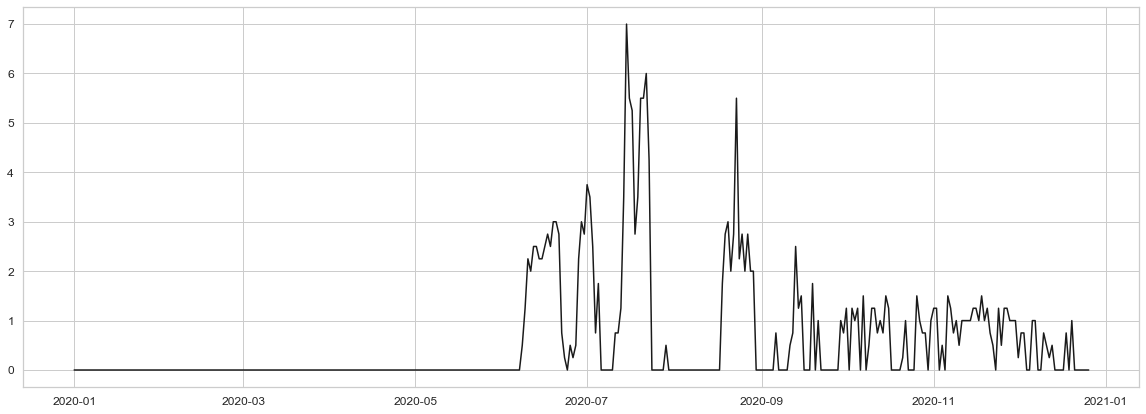

In [107]:
plt.figure(figsize = (20,7))

plt.plot(data['date'],summary_detail['HI German'], 'k')

Text(0.5, 0, 'date')

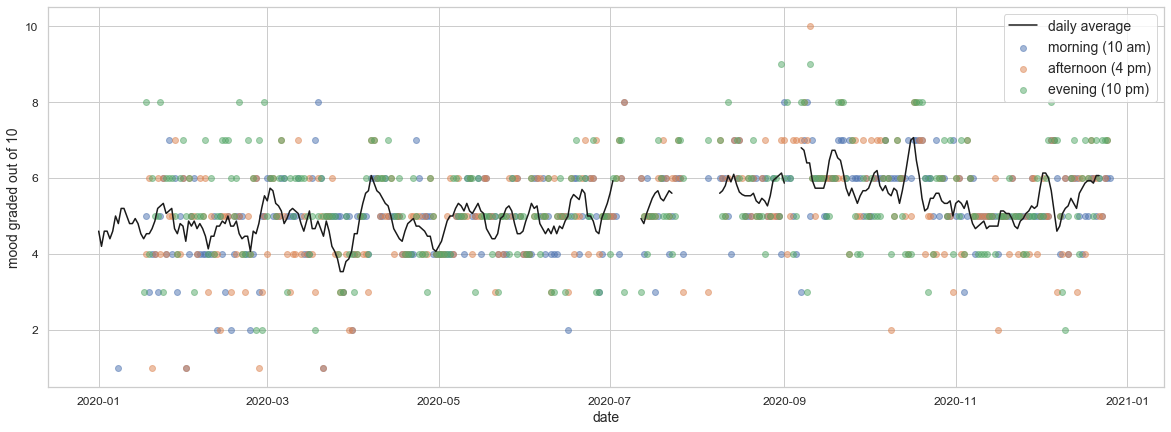

In [108]:
plt.figure(figsize = (20,7))

av_smooth = np.convolve(data['av_mood'], np.ones((5,))/5, mode='valid')
plt.plot(data['date'][:-4],av_smooth, 'k')

for item in ['morning', 'afternoon', 'evening'] :
    temp = data[item]
    #temp = temp[~np.isnan(temp)]
    plt.scatter(data['date'], temp, alpha = 0.5)


plt.legend(['daily average','morning (10 am)', 'afternoon (4 pm)', 'evening (10 pm)'])   
plt.ylabel('mood graded out of 10')
plt.xlabel('date')


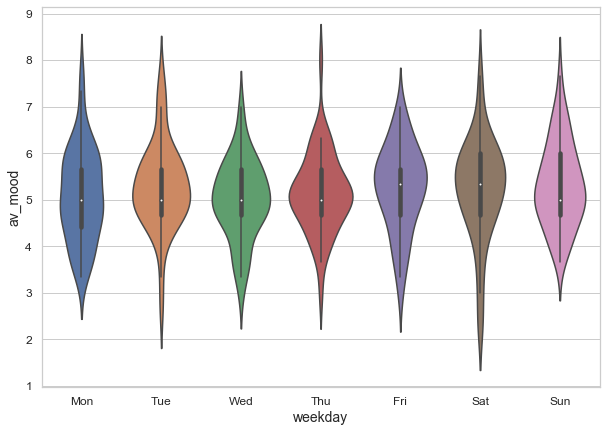

In [112]:
plt.figure(figsize = (10,7))

sns.violinplot(x = data['weekday'], y = data['av_mood'])

ax = plt.gca()
ax.set_xticklabels(weekdays_abb)

plt.show()

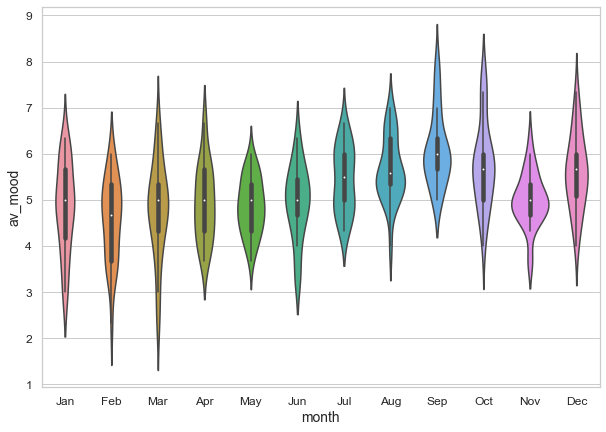

In [113]:
plt.figure(figsize = (10,7))

sns.violinplot(x = data['month'], 
               y = data['av_mood'])

n = len(np.unique(data['month']))

ax = plt.gca()
ax.set_xticklabels(months_abb[:n])

plt.show()

Mood and alcohol:

Ttest_indResult(statistic=nan, pvalue=nan)


C:\Users\Alicja\Work\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Alicja\Work\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Alicja\Work\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


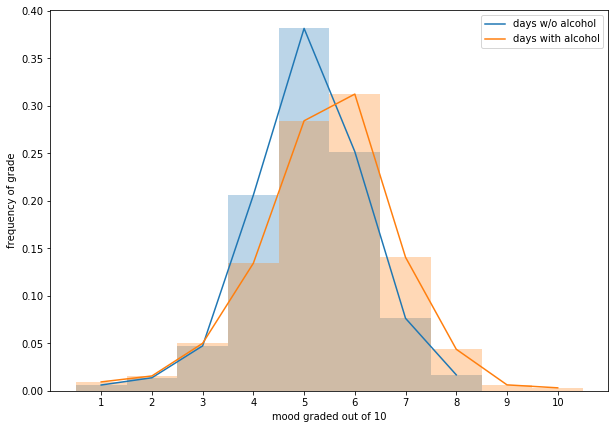

In [32]:
temp_num = data['alcohol?']

for i, cat in enumerate(['no', r'.*']):
    temp_num = temp_num.replace(regex=rf"{cat}", value = i)

plt.figure(figsize = (10,7))

for item in [0,1] :
    temp = data[temp_num == item][['morning', 'afternoon', 'evening']]
    temp = temp[~np.isnan(temp)]
    val, counts = np.unique(temp, return_counts = 1)
    counts = counts/sum(temp.count())
    plt.plot(val, counts)
    
nalc = np.array(data[temp_num == 0][['morning', 'afternoon', 'evening']]).flatten()
nalc = nalc[~np.isnan(nalc)]
alc = np.array(data[temp_num == 1][['morning', 'afternoon', 'evening']]).flatten()
alc = alc[~np.isnan(alc)]

nalbins = np.arange(start = min(nalc) - 0.5,stop =  max(nalc) + 1.5)
albins = np.arange(start = min(alc) - 0.5,stop =  max(alc) + 1.5)

plt.hist(nalc, bins = nalbins, color = colors[0], alpha = 0.3, density = 1)
plt.hist(alc, bins = albins, color = colors[1], alpha = 0.3, density = 1)
  
print(stats.ttest_ind(data['av_mood'][temp_num == 0], data['av_mood'][temp_num == 1]))
    
plt.legend(['days w/o alcohol', 'days with alcohol'])   
plt.xticks(range(1,11))
plt.xlabel('mood graded out of 10')
plt.ylabel('frequency of grade')
plt.show()

Mood and COVID

In [33]:
data['COV'] = 0

data['COV'][69:] = 1

C:\Users\Alicja\Work\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Ttest_indResult(statistic=nan, pvalue=nan)


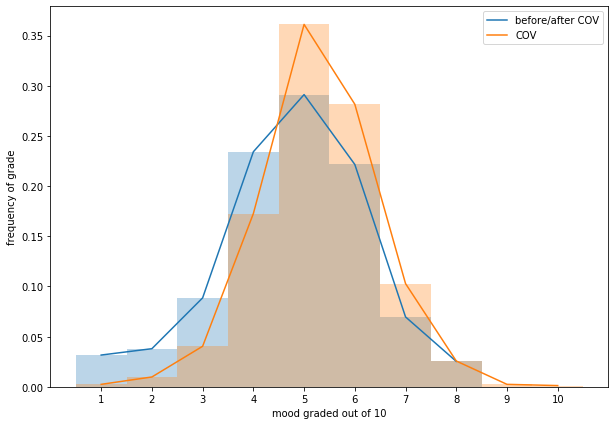

In [34]:
plt.figure(figsize = (10,7))

for item in [0,1] :
    temp = data[data['COV'] == item][['morning', 'afternoon', 'evening']]
    temp = temp[~np.isnan(temp)]
    val, counts = np.unique(temp, return_counts = 1)
    counts = counts/sum(temp.count())
    plt.plot(val, counts)
    
nocov = np.array(data[data['COV'] == 0][['morning', 'afternoon', 'evening']]).flatten()
nocov = nocov[~np.isnan(nocov)]
cov = np.array(data[data['COV'] == 1][['morning', 'afternoon', 'evening']]).flatten()
cov = cov[~np.isnan(cov)]

ncbins = np.arange(start = min(nocov) - 0.5,stop =  max(nocov) + 1.5)
cbins = np.arange(start = min(cov) - 0.5,stop =  max(cov) + 1.5)

plt.hist(nocov[~np.isnan(nocov)], bins = ncbins, color = colors[0], alpha = 0.3, density = 1)
plt.hist(cov[~np.isnan(cov)], bins = cbins, color = colors[1], alpha = 0.3, density = 1)
  
print(stats.ttest_ind(data['av_mood'][data['COV'] == 0], data['av_mood'][data['COV'] == 1]))
    
plt.legend(['before/after COV', 'COV'])   
plt.xticks(range(1,11))
plt.xlabel('mood graded out of 10')
plt.ylabel('frequency of grade')
plt.show()

#### Correlations

effect: -0.121 p-value: 0.025


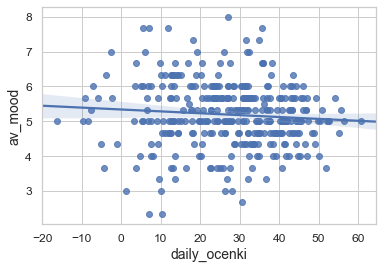

In [132]:
q = 'daily_ocenki'

sns.regplot(data[q], data['av_mood'])

c, p = stats.spearmanr(data[q][~np.isnan(data['av_mood'])], data['av_mood'][~np.isnan(data['av_mood'])])

print('effect: ' + str(round(c, 3)) + ' p-value: ' + str(round(p, 3)))

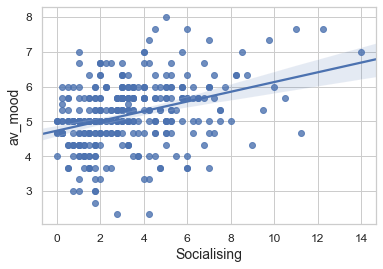

In [135]:
sns.regplot(summary_broad['Socialising'], data['av_mood'])

In [37]:
for column in summary_broad.columns:
    (r,p) = stats.spearmanr(summary_broad[column][~np.isnan(data['av_mood'])], data['av_mood'][~np.isnan(data['av_mood'])])
    if p < 0.05:
        print(column + ': ')
        print(f'effect: ' + str(round(r,3)) + ', p-value: {:0.3e}'.format(p))

sleep: 
effect: -0.256, p-value: 1.485e-06
High intensity work: 
effect: -0.263, p-value: 7.773e-07
Low intensity work: 
effect: -0.106, p-value: 4.911e-02
Procrastination: 
effect: -0.346, p-value: 4.070e-11
Culture: 
effect: -0.224, p-value: 2.723e-05
Socialising: 
effect: 0.354, p-value: 1.283e-11
Other quality time: 
effect: -0.147, p-value: 6.306e-03
Travelling: 
effect: 0.235, p-value: 1.065e-05
High intensity exercise: 
effect: 0.188, p-value: 4.626e-04
Low intensity exercise: 
effect: 0.337, p-value: 1.373e-10


### Calendars

A function make_calendar will return a calendar (rows being months and column being days) showing either continuous or discrete values <br>
Kind of still working on it, especially the side bar

In [128]:
def make_calendar(data, values, title, cols, categorical = False, *args, **kwargs):
    
    months = ('January', 'February', 'March', 'April', 'May', 'June',
         'July', 'August', 'September', 'October', 'November', 'December')
    
    temp = data.pivot(index = 'month', columns = 'day', values = values)
    n = len(temp.index)

    mask = pd.isnull(temp)
    temp_num = temp.fillna(0)

    if categorical == True:
        cats = args[0]
        for i, cat in enumerate(cats):
            temp_num = temp_num.replace(regex=rf"{cat}", value = i)

    #plot heatmap - size will change depending on the number of months in data
    
    #plt.figure(figsize = (1.3*12,1.3*n))
    if categorical: plt.figure(figsize = (1.1*12,1.1*n))
    else: plt.figure(figsize = (1.3*12,1.3*n))
    
    if categorical: cbar_bool = False
    else: cbar_bool = True
    
    sns.heatmap(temp_num, mask=mask, 
                cbar = cbar_bool, cbar_kws={"shrink": 0.3, 'aspect':12, 'pad': 0.02},
                linewidth = 0.05, square = 1, 
                cmap = cols, **kwargs)
    
    #move day labels to the top and get rid of tick marks
    ax = plt.gca()
    plt.gca().xaxis.tick_top()
    ax.tick_params(length = 0)

    #get rid of axis labels as self-explanatory
    #add title
    plt.xlabel('')
    plt.ylabel('')
    plt.title(title)
    
    
    bottom, top = ax.get_ylim()
    #change numbers to month names on the heatmap
    plt.yticks(np.arange(n)+0.5, months[:n], rotation=0, va="center")
    #fix the weird bug which changes dimensions of first and last row
    ax.set_ylim(bottom + 0.5, top - 0.5)

    ax.set_facecolor("white")
    
    #if data is categorical, fix the colorbar
    if categorical:
        cat_names = args[1]
        
        legend_patches = [mpatches.Patch(color = cmap[i], label = name) for i, name in enumerate(cat_names)]
        plt.legend(handles=legend_patches, handlelength = 1, handleheight = 1,
                  bbox_to_anchor=(1.01, 0.5), loc='center left', 
                  framealpha = 0)

    plt.show()

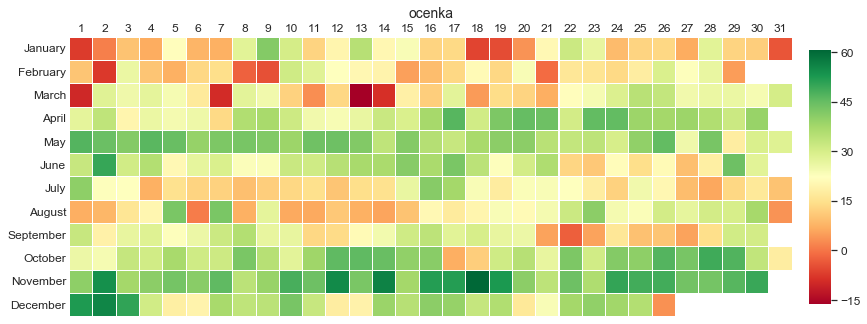

In [129]:
make_calendar(data, 'daily_ocenki', 'ocenka', 'RdYlGn')

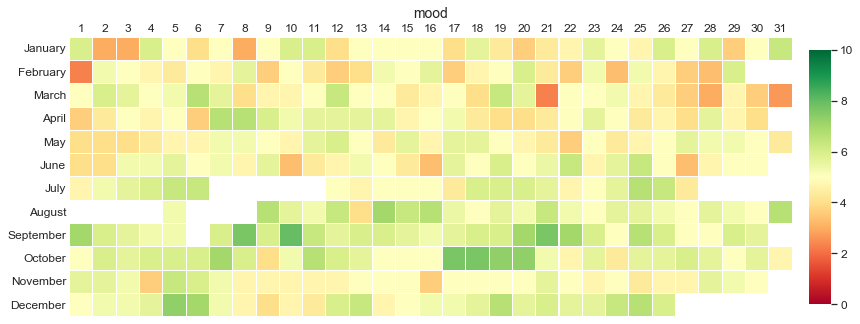

In [130]:
make_calendar(data, 'av_mood', 'mood', 'RdYlGn', **{'center' : 5, 'vmin': 0, 'vmax': 10 })

['CH' 'DE' 'DK' 'PL' 'SE' 'TR' 'UK']


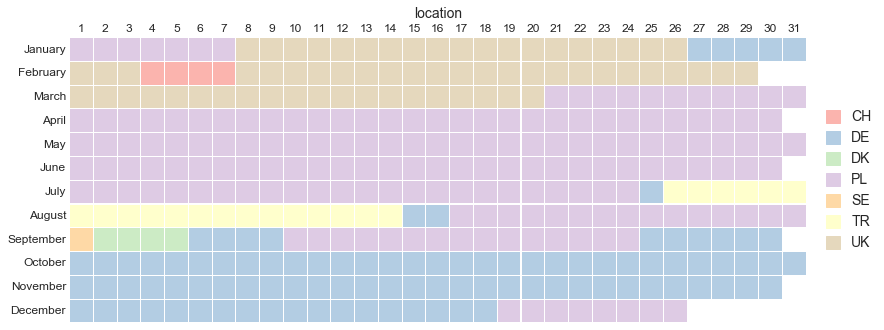

In [123]:
loc_u = pd.unique(data['location'])

#print(loc_u)

countries = np.unique([text.split(', ')[0] for text in loc_u])
print(countries)
cities = np.unique([text.split(', ')[1] for text in loc_u])

#cmap = ['#BBF6D4', '#c899e8', '#e6a1c5',  '#e0d75a', '#AECFF9']
cmap = [ cm.Pastel1(x) for x in range(len(countries))]

cats_reg = [rf"^{country},.*" for country in countries]

make_calendar(data, 'location', 'location', cmap, True, cats_reg, countries)

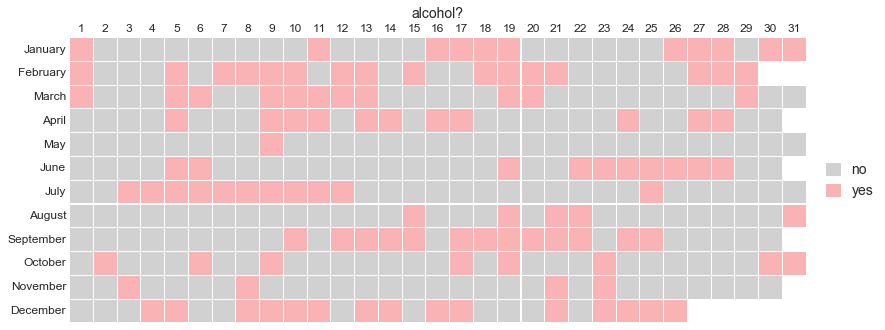

In [124]:
#cmap = ['#D1D1D1', '#abd69c', '#F9B3B5']
cmap = ['#D1D1D1',  '#F9B3B5']

#categs = ['no', 'hmm', r'.*']
categs = ['no', r'.*']

#make_calendar(data, 'alcohol?', 'alcohol?', cmap, True, categs, ['no','weed', 'yes'])
make_calendar(data, 'alcohol?', 'alcohol?', cmap, True, categs, ['no', 'yes'])

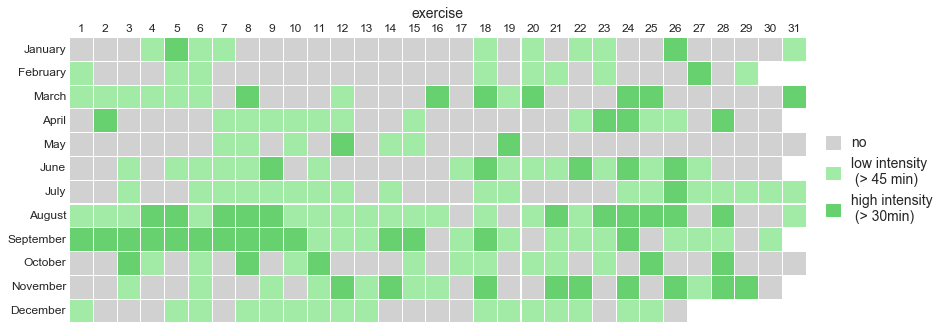

In [158]:
#summary_detail['Low intensity exercise'] > 0.5

data_ex = data.copy()

data_ex['exercise'] = np.where(summary_detail['Low intensity exercise'] > 0.75, 1, 0)
data_ex['exercise'] = np.where(summary_detail['High intensity exercise'] > 0.5, 2, data_ex['exercise'])

cmap = ['#D1D1D1',  '#a2eba7', '#66d16e']

make_calendar(data_ex, 'exercise', 'exercise', cmap, True, [0,1,2], ['no', 'low intensity \n (> 45 min)', 'high intensity \n (> 30min)'])

### People 

A heatmap of time spent with people, with friends being blue and family being red

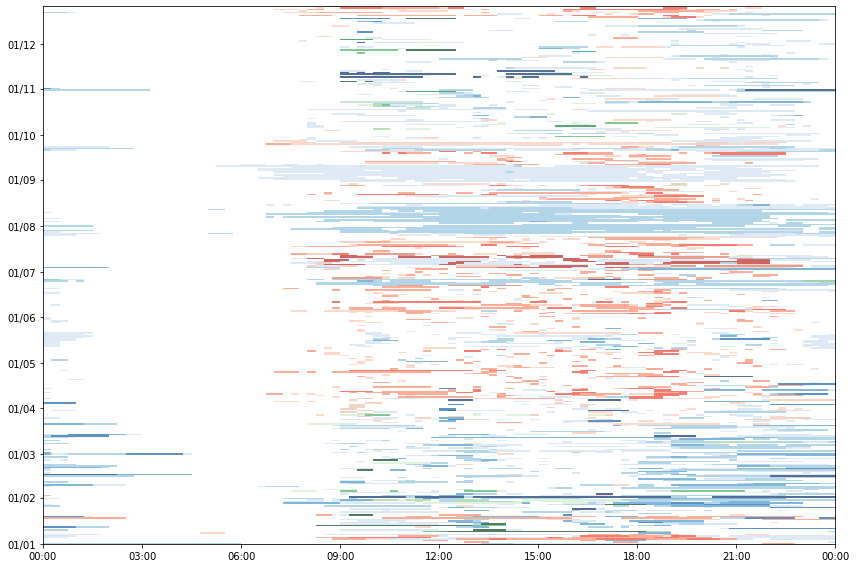

In [45]:
friends = activities.replace(regex=r'^((?!Fr).)*$', value = '0')

for column in friends.columns:
    friends[column] = friends[column].str.extract('(\d+)')
    friends[column] = pd.to_numeric(friends[column])
    
family = activities.replace(regex=r'^((?!Fam).)*$', value = '0')

for column in family.columns:
    family[column] = family[column].str.extract('(\d+)')
    family[column] = pd.to_numeric(family[column])
    
randoms = activities.replace(regex=r'^((?!_R_).)*$', value = '0')

for column in randoms.columns:
    randoms[column] = randoms[column].str.extract('(\d+)')
    randoms[column] = pd.to_numeric(randoms[column])

#set the scales to represent datatime
y_lims = dates.date2num((activities.index[0], activities.index[-1]))
x_lims = dates.date2num((datetime.datetime(2000, 1, 1, 0, 0), datetime.datetime(2000, 1, 2, 0, 0)))

#normalise the data across the three dataframes

bounds = np.array([0, 1, 2, 4, 6, 10, 15])

norm = mcolors.BoundaryNorm(boundaries=bounds, ncolors=256)
    
#plot all three dataframes, using separate color scales
fig, ax = plt.subplots(figsize=(12,8))
fr = ax.imshow(friends[friends != 0], cmap = 'Blues',  norm = norm, #norm=colors.LogNorm(),
          extent = [x_lims[0], x_lims[1],  y_lims[1], y_lims[0]], aspect='auto', alpha = 0.7)
#fig.colorbar(fr, shrink=0.25)
fam = ax.imshow(family[family != 0], cmap = 'Reds', norm = norm, #norm=colors.LogNorm(),
          extent = [x_lims[0], x_lims[1],  y_lims[1], y_lims[0]], aspect='auto', alpha = 0.7)
#fig.colorbar(fam, shrink=0.25)
rand = ax.imshow(randoms[randoms != 0], cmap = 'Greens', norm = norm, #norm=colors.LogNorm(),
          extent = [x_lims[0], x_lims[1],  y_lims[1], y_lims[0]], aspect='auto', alpha = 0.7)
#fig.colorbar(rand, shrink=0.25)

ax.xaxis_date()
ax.yaxis_date()

date_fmt = dates.DateFormatter('%d/%m')
ax.yaxis.set_major_formatter(date_fmt)
ax.invert_yaxis()

time_fmt = dates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(time_fmt)

plt.tight_layout()
plt.show()

In [46]:
friends_bin = friends.copy()
friends_bin[friends_bin != 0] = 1

family_bin = family.copy()
family_bin[family_bin != 0] = 1

randoms_bin = randoms.copy()
randoms_bin[randoms_bin != 0] = 1

totals_bin = friends_bin + family_bin + randoms_bin
totals_bin[totals_bin != 0] = 1

Text(0.5, 1.0, 'At what time am I most likely to spend time with:')

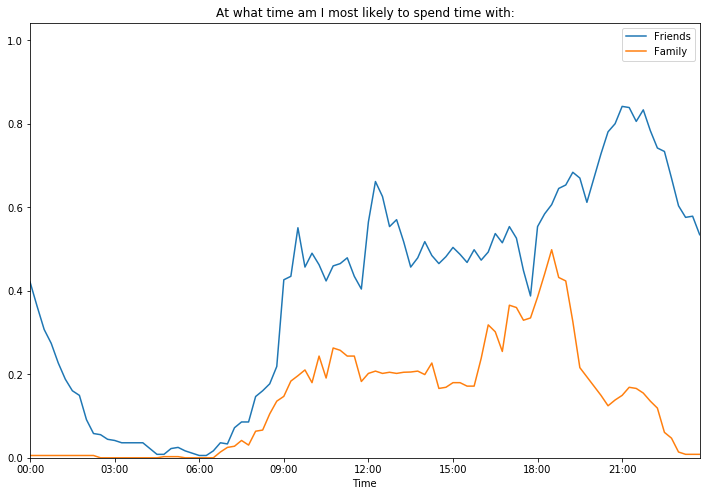

In [47]:
arb_date = datetime.date(2000, 1, 1)

times = [ datetime.datetime.combine(arb_date, time) for time in friends.columns ]

fig, ax = plt.subplots(figsize=(12,8))
plt.plot(times,friends.mean())
plt.plot(times,family.mean())

ax = plt.gca()

date_fmt = dates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(date_fmt)
ax.set_xlim([times[0], times[-1]])
ax.set_ylim([0, max(friends.mean()) + 0.2])

plt.legend(['Friends', 'Family']) 
#plt.ylabel('Average number of friends')
plt.xlabel('Time')
plt.title('At what time am I most likely to spend time with:')

### Other Funky Stuff

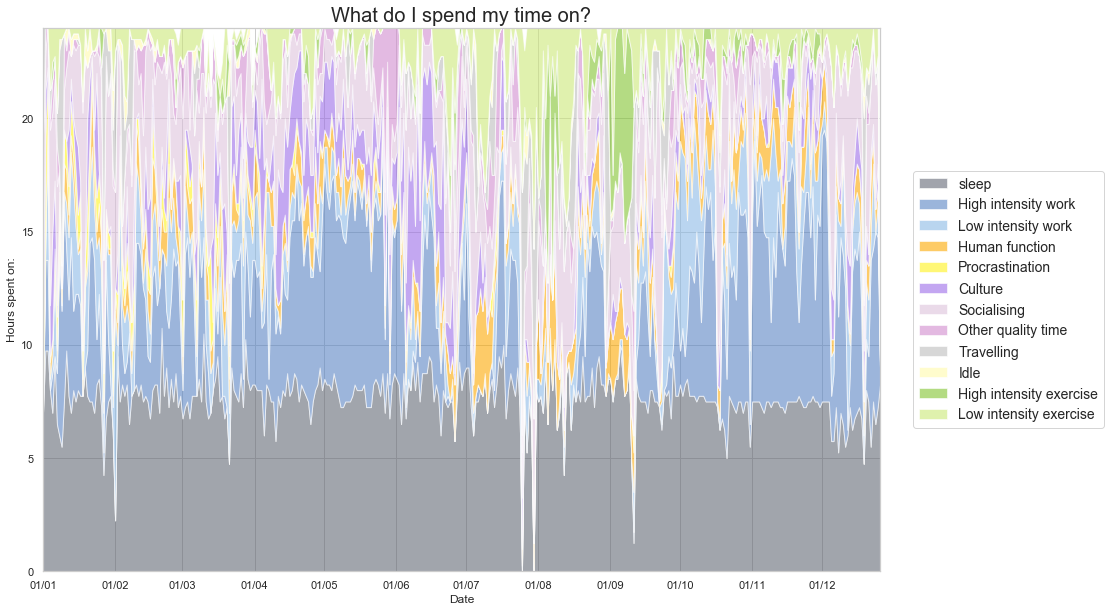

In [48]:
colors = ['#636975', '#5a85c4', '#8cbae6', '#fca903', '#fff41c', '#9c6de8', '#dec3dd', '#d18ccf', '#bdbdbd', '#fffbad','#82c431', '#cce879']

fig = plt.figure(figsize = (15,10))
sns.set(style="whitegrid")

plt.stackplot(summary_broad.index.values, summary_broad.values.T, 
              labels = summary_broad.columns, colors = colors, alpha = 0.6)


plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0, prop={'size': 14})
plt.title('What do I spend my time on?', size = 20, weight = 'ultralight')
plt.xlabel('Date')
plt.ylabel('Hours spent on:')

ax = plt.gca()
date_fmt = dates.DateFormatter('%d/%m')
ax.xaxis.set_major_formatter(date_fmt)

ax.set_ylim([0,24])
ax.set_xlim([summary_broad.index.values[0], summary_broad.index.values[-1]])

plt.show()

Sleeping patterns

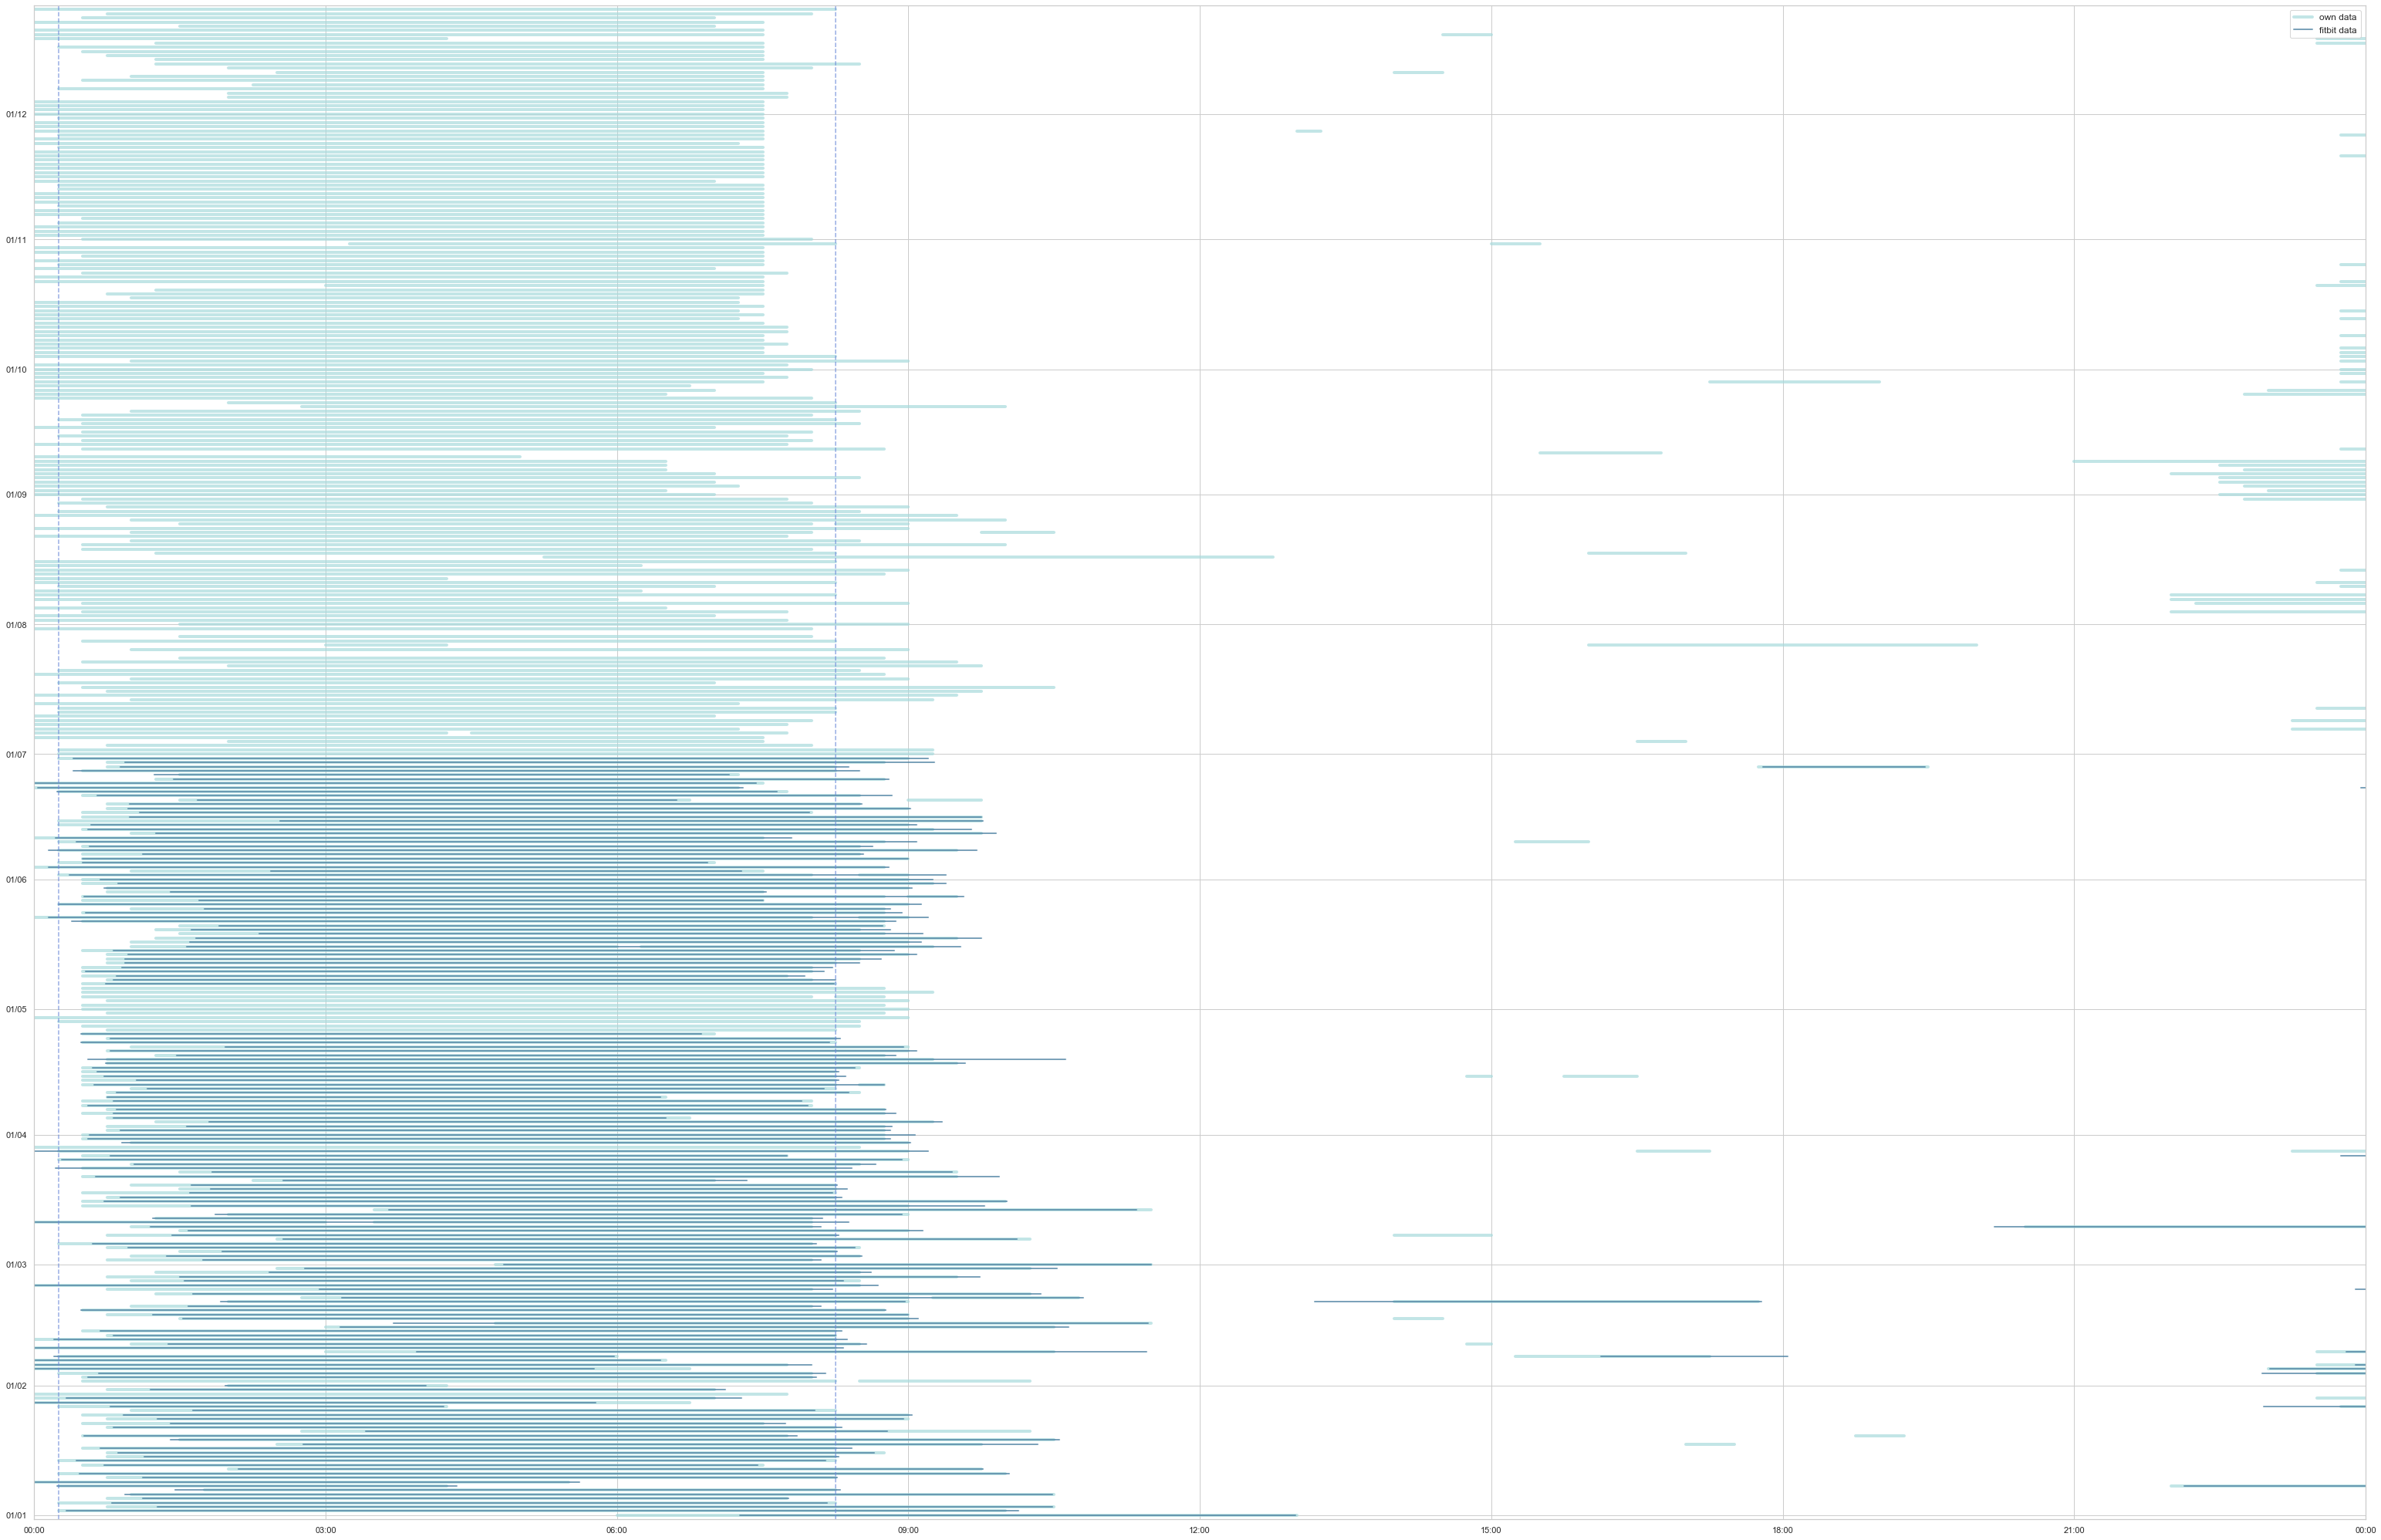

In [49]:
#make an arbitrary date to add to hours so they display nicely on the x-axis
#it's an ugly solution but couldn't figure anything better
arb_date = datetime.date(2000, 1, 1)

h = 0.1*len(activities.index)

fig = plt.figure(figsize = (1.5*h,h))

#set colors - light theme
sns.set(style="whitegrid")
fitbit_color = '#457B9D'
own_color = '#A8DADC'
f_a = 0.7
o_a = 0.7

#set colors - dark theme
#sns.set_style("darkgrid", {"axes.facecolor": '#457B9D', 'grid.color': '#8dc7eb'})
#fitbit_color = '#67f5f5'
#own_color = 'white'
#o_a = 0.9

#plot data from spreadsheet
for j, row in enumerate(activities.index):
    #temp = activities.iloc[j,:].str.match('S')
    temp = activities.iloc[j,:] == 'S'
    sleep_times = []
    i = 0    
    while i < len(temp):
        if temp[i] == True:
            start = datetime.datetime.combine(arb_date, temp.index[i])
            while temp[i] == True and temp.index[i] < datetime.time(23,45):
                i += 1
            if temp.index[i] < datetime.time(23,45):
                end = datetime.datetime.combine(arb_date, temp.index[i])
            else:
                end = datetime.datetime.combine(datetime.date(2000, 1, 2), datetime.time(0,0))
            plt.plot((start, end), (row, row), lw = 4, color = own_color, alpha = o_a)
            
        i += 1

#plot fitbit data
for i, row in fitbit_sleep.iterrows():
    
    s_date = row['Start Time'].date()
    e_date = row['End Time'].date()
    
    start = datetime.datetime.combine(arb_date, row['Start Time'].time())
    end = datetime.datetime.combine(arb_date, row['End Time'].time())
    
    if s_date == e_date:
        plt.plot((start, end), (s_date, e_date), lw = 2, color = fitbit_color, alpha = f_a)
        
    else: 
        f_end = datetime.datetime.combine(datetime.date(2000, 1, 2), datetime.time(0,0))
        f_start = datetime.datetime.combine(arb_date, datetime.time(0,0))
        
        plt.plot((start, f_end),(s_date, s_date), lw = 2, color = fitbit_color, alpha = f_a)
        plt.plot((f_start, end), (e_date, e_date), lw = 2, color = fitbit_color, alpha = f_a)
        
#draw a legend
legend_lines = [Line2D([0], [0], color=own_color, lw=4, alpha = o_a),
                Line2D([0], [0], color=fitbit_color, lw=2, alpha = f_a)]
plt.legend(legend_lines, ('own data', 'fitbit data'), prop={'size': 12})
        
ax = plt.gca()
#ax.set_facecolor('white')

#nicer axes labels
date_fmt = dates.DateFormatter('%d/%m')
ax.yaxis.set_major_formatter(date_fmt)

time_fmt = dates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(time_fmt)
#limits of x axis to display time between midnight and midninght
ax.set_xlim([datetime.datetime(2000, 1, 1, 0, 0), datetime.datetime(2000, 1, 2, 0, 0)])
ax.set_ylim([activities.index[0]-datetime.timedelta(days=1), activities.index[-1]+datetime.timedelta(days=1)])

#add horisontal lines to mark desired sleeping pattern
plt.axvline(x=datetime.datetime.combine(arb_date, datetime.time(0,15)), 
            ls = '--', alpha = 0.7, color = '#6a88d9')
plt.axvline(x=datetime.datetime.combine(arb_date, datetime.time(8,15)), 
            ls = '--', alpha = 0.7, color = '#6a88d9')

#could use this to change colors of the plot background - eg dark before sunrise and light at sunrise
#for i in range(0, 5):
#    plt.axhspan(i, i+.2, facecolor='0.2', alpha=0.5)
#    plt.axvspan(i, i+.5, facecolor='b', alpha=0.5)

Text(1.035, 0.4182825484764543, 'exams')

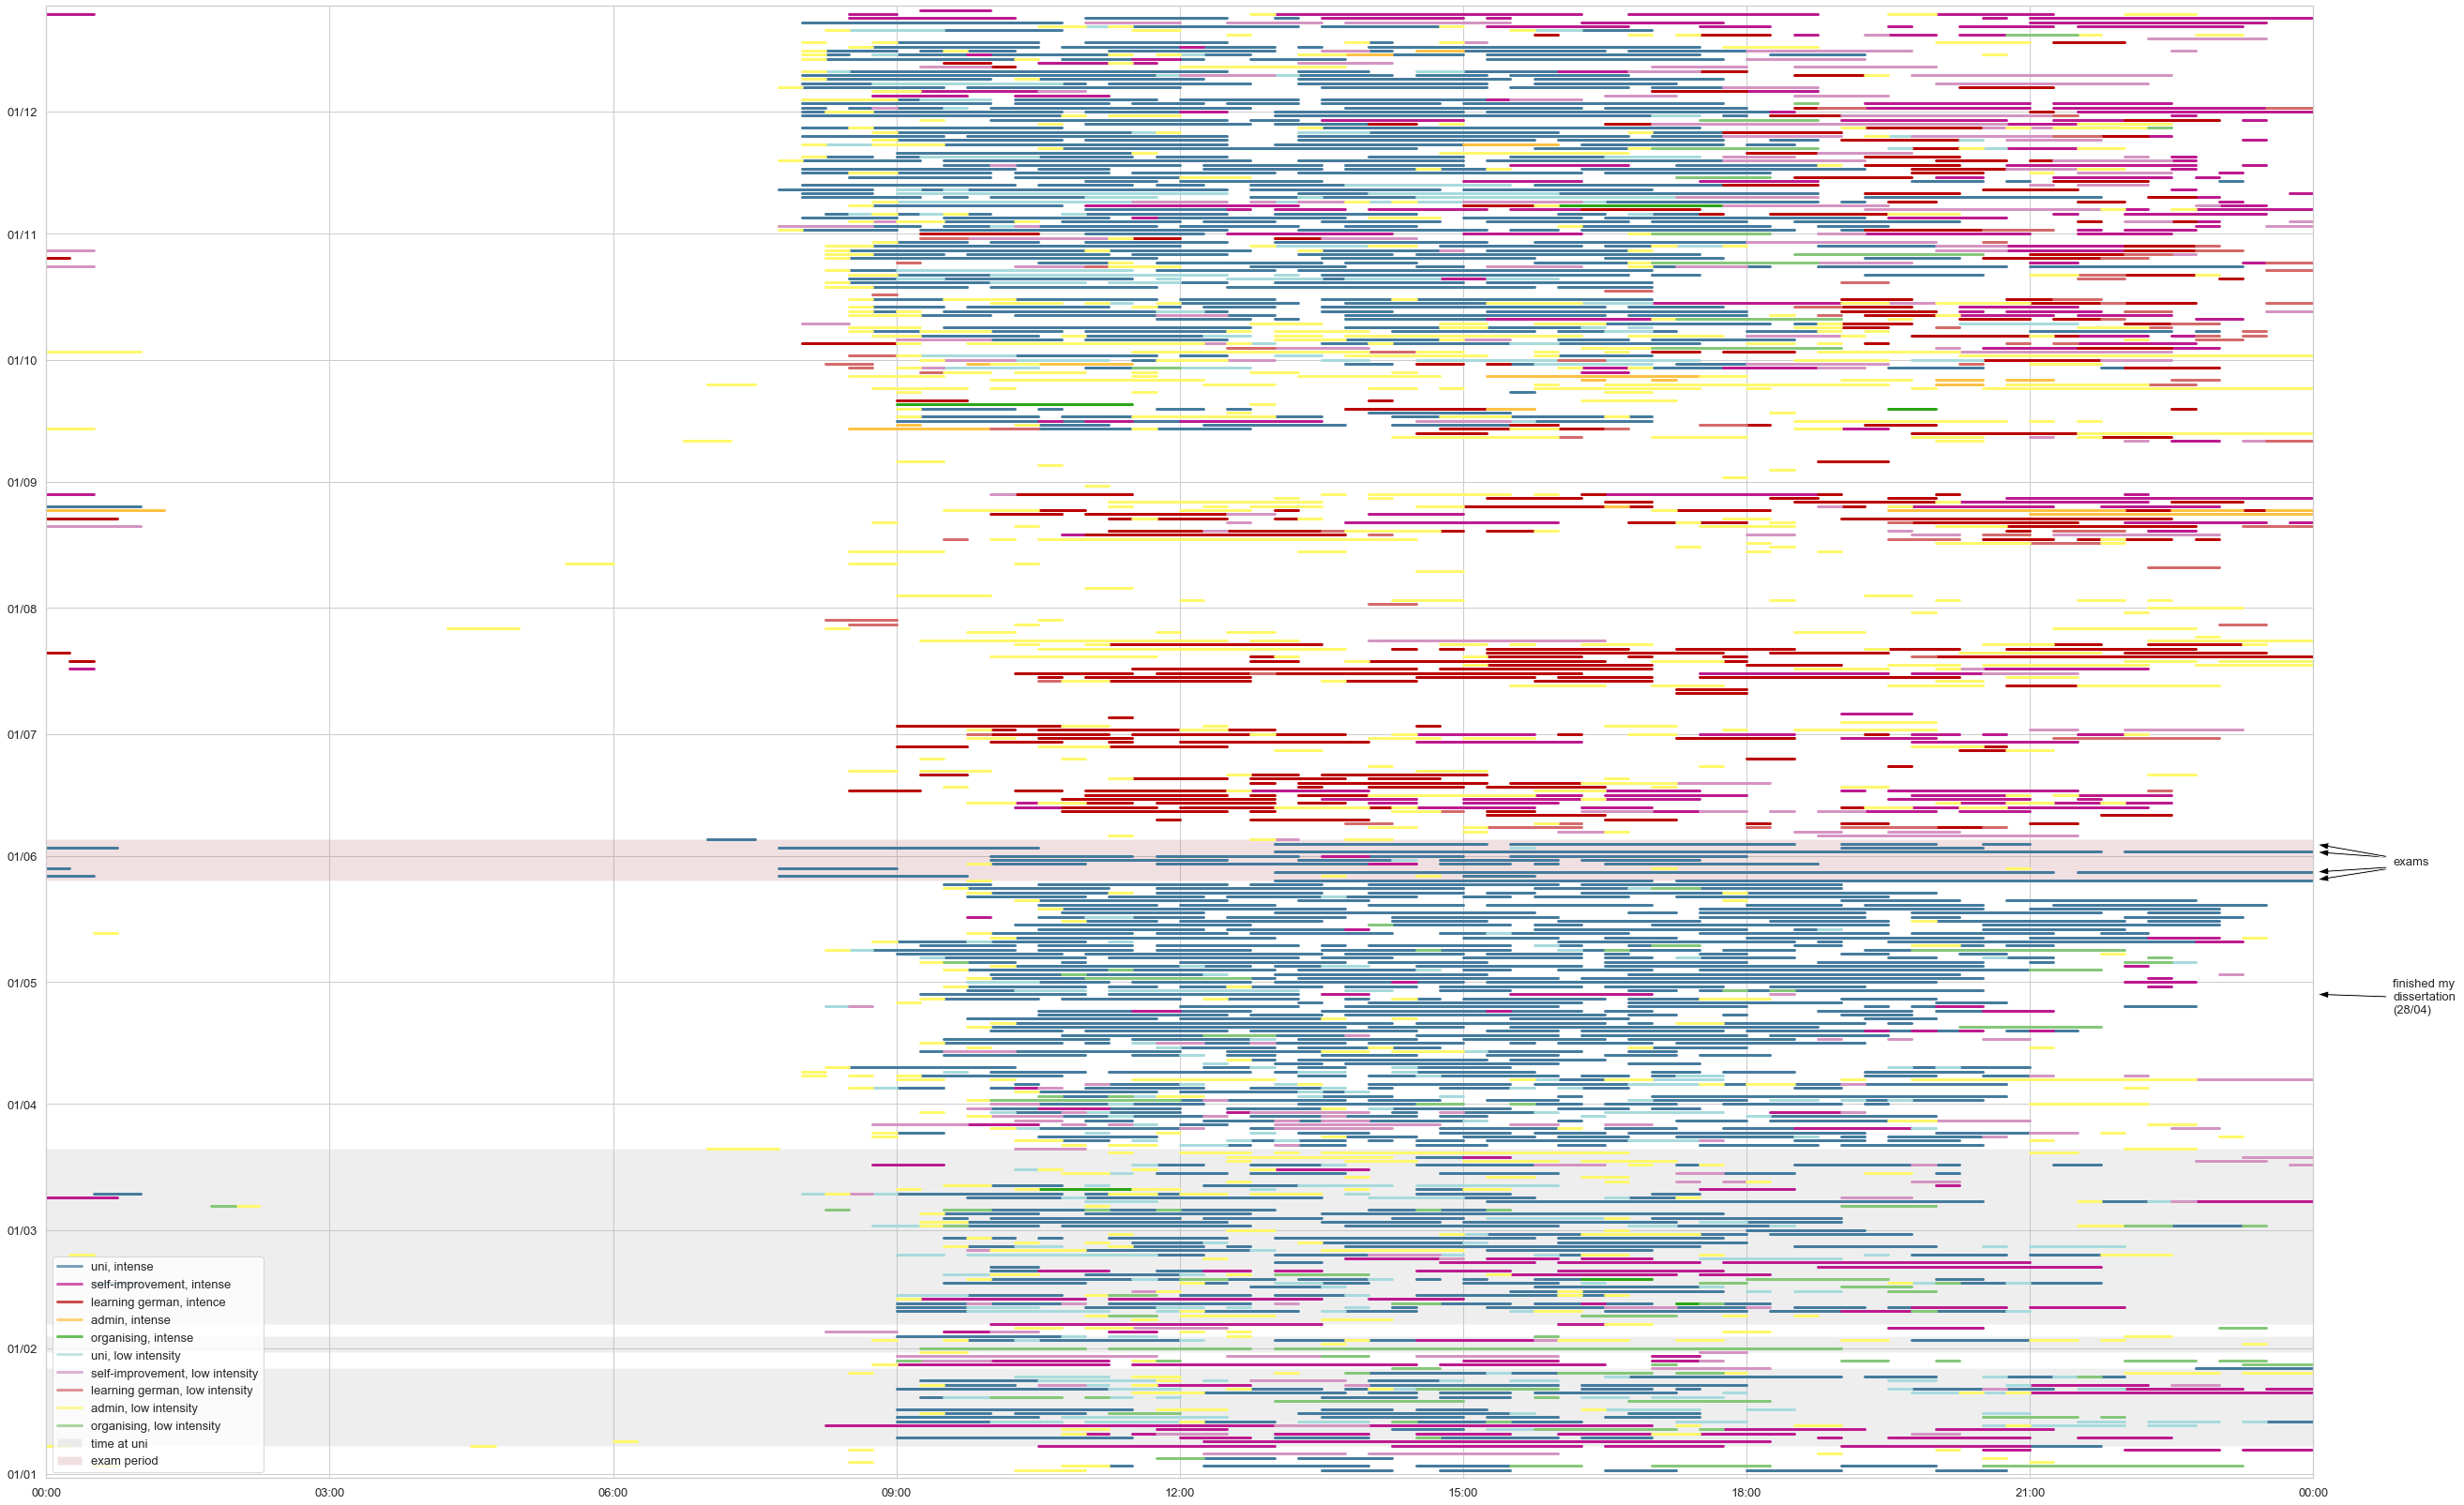

In [50]:
# colors_alt = ['#4d7db8', '#b55ca3', '#fcf753', '#7ec96f',
#         '#9cbde6', '#e0b4d7', '#faf8b1','#9fd494']
#these colours were used in a different plot about working - quite nice

#make an arbitrary date to add to hours so they display nicely on the x-axis
#it's an ugly solution but couldn't figure anything better

arb_date = datetime.date(2000, 1, 1)

h = 0.1*len(activities.index)

fig = plt.figure(figsize = (1.2*h,0.8*h))

#set colors - light theme
sns.set(style="whitegrid")
#fitbit_color = '#457B9D'
uniint = '#457B9D'
alpha = 0.7
lw = 3

#set colors - dark theme
#sns.set_style("darkgrid", {"axes.facecolor": '#457B9D', 'grid.color': '#8dc7eb'})
#fitbit_color = '#67f5f5'
#own_color = 'white'
#o_a = 0.9

shortcuts = [r'^WI-U.*', r'^WI-I.*', r'^WI-Ger.*', r'^WI-A.*', r'^WI-O.*', 
             r'^WL-U.*', r'^WL-I.*', r'^WL-Ger.*', r'^WL-A.*', r'^WL-O.*']
cols = ['#457B9D', '#bd1a8f', '#ba0000', '#ffc145', '#2ba616',
        '#A8DADC', '#d494c2', '#d46a6a', '#fff86b', '#85c779']

#plot data from spreadsheet

for r, col in zip(shortcuts, cols):
    for j, row in enumerate(activities.index):
        temp = activities.iloc[j,:].str.match(r)
        work = []
        i = 0    
        while i < len(temp):
            if temp[i] == True:
                start = datetime.datetime.combine(arb_date, temp.index[i])
                while temp[i] == True and temp.index[i] < datetime.time(23,45):
                    i += 1
                if temp.index[i] < datetime.time(23,45):
                    end = datetime.datetime.combine(arb_date, temp.index[i])
                else:
                    end = datetime.datetime.combine(datetime.date(2000, 1, 2), datetime.time(0,0))
                plt.plot((start, end), (row, row), lw = lw, color = col)#, alpha = alpha)

            i += 1

        
#draw a legend
ts = 13 #textsize
legend_lines = [Line2D([0], [0], color=col, lw=lw, alpha = alpha) for col in cols]
legend_patches = [mpatches.Patch(facecolor='#acaeb0', alpha = 0.2), mpatches.Patch(facecolor='#ba666c', alpha = 0.2)]
legend_els = legend_lines + legend_patches
cat_names = ['uni, intense', 'self-improvement, intense', 'learning german, intence', 'admin, intense', 'organising, intense', 
             'uni, low intensity', 'self-improvement, low intensity', 'learning german, low intensity', 'admin, low intensity', 'organising, low intensity',
            'time at uni', 'exam period']
plt.legend(legend_els, cat_names, loc =  'lower left', prop={'size': ts})
        
ax = plt.gca()
#ax.set_facecolor('white')

#nicer axes labels
date_fmt = dates.DateFormatter('%d/%m')
ax.yaxis.set_major_formatter(date_fmt)
ax.tick_params(labelsize = ts)

time_fmt = dates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(time_fmt)
#limits of x axis to display time between midnight and midninght
ax.set_xlim([datetime.datetime(2000, 1, 1, 0, 0), datetime.datetime(2000, 1, 2, 0, 0)])
ax.set_ylim([activities.index[0]-datetime.timedelta(days=1), activities.index[-1]+datetime.timedelta(days=1)])

term_1_start = datetime.datetime(2020, 1, 8, 0, 0)
term_1_end = datetime.datetime(2020, 3, 13, 0, 0)
came_home = datetime.datetime(2020, 3, 21, 0, 0)

dresden_start = datetime.datetime(2020, 1, 27, 0, 0)
dresden_end = datetime.datetime(2020, 1, 31, 0, 0)

zurich_start = datetime.datetime(2020, 2, 4, 0, 0)
zurich_end = datetime.datetime(2020, 2, 7, 0, 0)

term_2_start = datetime.datetime(2020, 4, 21, 0, 0)
term_2_end = datetime.datetime(2020, 6, 12, 0, 0)

exams_start = datetime.datetime(2020, 5, 26, 0, 0)
exams_end = datetime.datetime(2020, 6, 5, 0, 0)

#coloured parts of plot
plt.axhspan(term_1_start, dresden_start, facecolor='#acaeb0', alpha=0.2)
plt.axhspan(dresden_end, zurich_start, facecolor='#acaeb0', alpha=0.2)
plt.axhspan(zurich_end, came_home, facecolor='#acaeb0', alpha=0.2)
#plt.axhspan(term_2_start, term_2_end, facecolor='#acaeb0', alpha=0.2)
plt.axhspan(exams_start, exams_end, facecolor='#ba666c', alpha=0.2)

#annotations


ax.annotate('finished my \ndissertation\n(28/04)', xy=(datetime.datetime(2000, 1, 2, 0, 0), datetime.datetime(2020, 4, 28, 0, 0)),  xycoords='data',
            xytext=(1.035, 118/len(activities.index)), textcoords='axes fraction', size = ts,
            arrowprops=dict(facecolor='black', shrink=0.05, width = 2, headwidth = 8),
            horizontalalignment='left', verticalalignment='center',
            )

ax.annotate('exams', xy=(datetime.datetime(2000, 1, 2, 0, 0), datetime.datetime(2020, 5, 26, 0, 0)),  xycoords='data',
            xytext=(1.035, 151/len(activities.index)), textcoords='axes fraction', size = ts,
            arrowprops=dict(facecolor='black', shrink=0.05, width = 2, headwidth = 8),
            horizontalalignment='left', verticalalignment='center',
            )

ax.annotate('exams', xy=(datetime.datetime(2000, 1, 2, 0, 0), datetime.datetime(2020, 5, 28, 0, 0)),  xycoords='data',
            xytext=(1.035, 151/len(activities.index)), textcoords='axes fraction', alpha = 0,
            arrowprops=dict(facecolor='black', shrink=0.05, width = 2, headwidth = 8),
            horizontalalignment='left', verticalalignment='center',
            )

ax.annotate('exams', xy=(datetime.datetime(2000, 1, 2, 0, 0), datetime.datetime(2020, 6, 2, 0, 0)),  xycoords='data',
            xytext=(1.035, 151/len(activities.index)), textcoords='axes fraction', alpha = 0,
            arrowprops=dict(facecolor='black', shrink=0.05, width = 2, headwidth = 8),
            horizontalalignment='left', verticalalignment='center',
            )

ax.annotate('exams', xy=(datetime.datetime(2000, 1, 2, 0, 0), datetime.datetime(2020, 6, 4, 0, 0)),  xycoords='data',
            xytext=(1.035, 151/len(activities.index)), textcoords='axes fraction', alpha = 0,
            arrowprops=dict(facecolor='black', shrink=0.05, width = 2, headwidth = 8),
            horizontalalignment='left', verticalalignment='center',
            )

#plt.savefig('work.png', quality = 95)